In [2]:
import numpy as np
from sympy import Line
import torch
from torch import Tensor
import sys, os
import pickle
import scipy
from scipy.optimize import curve_fit
import torch.optim as optim

from torchquad import set_up_backend  # Necessary to enable GPU support
from torchquad import Trapezoid, Simpson, Boole, MonteCarlo, VEGAS, GaussLegendre # The available integrators
from torchquad.utils.set_precision import set_precision
import torchquad
from functools import partial
import matplotlib.pyplot as plt
from pathlib import  Path
import torch.nn as nn

from LinearAxion_NN import LinearAxion_NN, S_integral, l_integral, _h, _f
from LinearAxion import power_law_fit, f_for_fit, get_thermal_entropy

/home/bigbogo/miniconda3/envs/3.10/lib/python3.10/site-packages/torch/__init__.py:955: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /opt/conda/conda-bld/pytorch_1724789122112/work/torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)


In [3]:
# Use this to enable GPU support and set the floating point precision
set_up_backend("torch", data_type="float64")
# torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [4]:
def calc_loss(S_pred, l_pred, s_thermal_pred, s_thermal_true, Sl_fit_func, popt):
    """
    Loss function for the model. (4.11) in paper
    """
    interpolated_S = Sl_fit_func(l_pred, *popt)

    # mae
    S_loss = torch.mean(torch.abs(S_pred - interpolated_S))
    s_thermal_loss = torch.mean(torch.abs(s_thermal_pred - s_thermal_true))
    loss = S_loss + s_thermal_loss
    return {"S_loss": S_loss, "s_thermal_loss": s_thermal_loss, "loss": loss}

def interpolate_S_l(data):
    popt, pcov = power_law_fit(data)
    return popt

In [5]:
# load data
dir = Path("data")
path = dir / "data.pkl"
print(f"Loading data from {path}")
data_loaded = pickle.load(open(path, "rb"))
mu = 0.5
beta = 0.5
N_zstar_points = 200
clipping_value = 0.1 # arbitrary value of your choosing
S_true = data_loaded[(mu, beta)]["SFinite"]
l_true = data_loaded[(mu, beta)]["l"]
zstar = data_loaded[(mu, beta)]["zstar"]
s_thermal_true = torch.tensor(data_loaded[(mu, beta)]["s_thermal"], requires_grad=False)
print(f"{zstar.shape=}, {S_true.shape=}, {s_thermal_true.shape=}")

print(data_loaded[(mu, beta)]["SFinite"])
print(data_loaded[(mu, beta)]["l"])
print(data_loaded[(mu, beta)]["zstar"])
# S_l_interpolated = interpolate_S_l(data_loaded[(mu, beta)])
popt = interpolate_S_l(data_loaded[(mu, beta)])

zstar_list = torch.tensor(np.linspace(0.10, 0.999, N_zstar_points), requires_grad=False)

Loading data from data/data.pkl
zstar.shape=(5000,), S_true.shape=(5000,), s_thermal_true.shape=torch.Size([])
[-9.99901821e+05 -3.24249766e+03 -1.54747910e+03 ...  9.64715542e-01
  9.87172398e-01  1.01134890e+00]
[9.98927944e-07 2.32016718e-04 4.63190921e-04 ... 3.59454715e+00
 3.63901050e+00 3.68689605e+00]
[1.0000000e-06 2.0103960e-04 4.0107922e-04 ... 9.9959892e-01 9.9979895e-01
 9.9999899e-01]


In [6]:
def h_helper(z):
    return _h(model, z)

In [77]:
epochs = 100
model = LinearAxion_NN(input_dim=1, output_dim=1, hidden_layers=[20, 20, 20])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 40, 60, 70, 80, 90, 95], gamma=0.5)
loss_hist = []
s_thermal_loss_hist = []
S_loss_hist = []
lr_hist = []
for epoch in range(epochs):
    zstar_list_noise = zstar_list + torch.randn_like(zstar_list) * 0.005 # add some noise
    zstar_list_noise = torch.clamp(zstar_list_noise, min=0.10, max=0.9999)  # avoid numerical issues
    if epoch == epochs:
        N_zstar_points = 1000
        zstar_list = torch.tensor(np.linspace(0.10, 0.999, N_zstar_points), requires_grad=False)
        zstar_list_noise = torch.tensor(np.linspace(0.10, 0.999, N_zstar_points), requires_grad=False)
    S_pred = S_integral(model, zstar_list_noise, N_GL=12)
    l_pred = l_integral(model, zstar_list_noise, N_GL=12)
    s_thermal_pred = get_thermal_entropy(h_helper, zh=torch.tensor(1.0))
    losses = calc_loss(S_pred, l_pred, s_thermal_pred, s_thermal_true, f_for_fit, popt)
    loss = losses["loss"]
    lr = optimizer.param_groups[0]["lr"]
    print(f"e={epoch}/{epochs}, s_thermal={s_thermal_pred.item():.3f}, lr={lr}, loss={loss.item():.3f}")

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), clipping_value)
    optimizer.step()
    scheduler.step()

    loss_hist.append(loss.item())
    s_thermal_loss_hist.append(losses["s_thermal_loss"].item())
    S_loss_hist.append(losses["S_loss"].item())
    lr_hist.append(lr)
    if loss.item is None or np.isnan(loss.item()):
        print("Loss is None or NaN, stopping training.")
        break


/home/bigbogo/miniconda3/envs/3.10/lib/python3.10/site-packages/autoray/autoray.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/bigbogo/miniconda3/envs/3.10/lib/python3.10/site-packages/torchquad/integration/utils.py:248: UserWarning: DEPRECATION WARNING: In future versions of torchquad, an array-like object will be returned.
  warnings.warn(


e=0/100, s_thermal=0.970, lr=0.01, loss=0.155
e=1/100, s_thermal=1.120, lr=0.01, loss=0.298
e=2/100, s_thermal=1.107, lr=0.01, loss=0.257
e=3/100, s_thermal=1.040, lr=0.01, loss=0.135
e=4/100, s_thermal=0.943, lr=0.01, loss=0.086
e=5/100, s_thermal=0.923, lr=0.01, loss=0.083
e=6/100, s_thermal=0.947, lr=0.01, loss=0.061
e=7/100, s_thermal=0.992, lr=0.01, loss=0.014
e=8/100, s_thermal=1.051, lr=0.01, loss=0.071
e=9/100, s_thermal=1.079, lr=0.01, loss=0.095
e=10/100, s_thermal=1.080, lr=0.01, loss=0.095
e=11/100, s_thermal=1.060, lr=0.01, loss=0.090
e=12/100, s_thermal=1.024, lr=0.01, loss=0.072
e=13/100, s_thermal=0.978, lr=0.01, loss=0.083
e=14/100, s_thermal=0.955, lr=0.01, loss=0.106
e=15/100, s_thermal=0.949, lr=0.01, loss=0.104
e=16/100, s_thermal=0.956, lr=0.01, loss=0.081
e=17/100, s_thermal=0.973, lr=0.01, loss=0.043
e=18/100, s_thermal=0.998, lr=0.01, loss=0.010
e=19/100, s_thermal=1.031, lr=0.01, loss=0.061
e=20/100, s_thermal=1.049, lr=0.005, loss=0.091
e=21/100, s_thermal=1.

/home/bigbogo/Documents/Projects/HoloML/LinearAxion/LinearAxion.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return cn1 * x**(-1) + c0 + c1 * x + c2 * x**2 + c3 * x**3 + c4 * x**4 + c5 * x**5


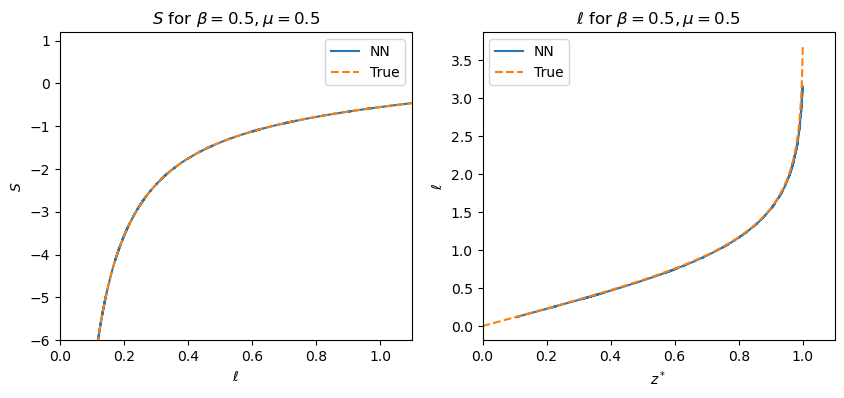

In [78]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=True)

plt.sca(axs[0])
plt.plot(l_pred.detach().cpu().numpy(), S_pred.detach().cpu().numpy(), label="NN")
plt.plot(l_true, S_true, label="True", ls="--")
l_list = np.linspace(0, 3.5, 100)
interpolated_S = np.array([f_for_fit(l, *popt) for l in l_list])
# plt.plot(l_list, interpolated_S, label="Interpolated", ls="--")
plt.xlabel("$\ell$")
plt.ylabel("$S$")
plt.title(r"$S$ for $\beta={:.1f}, \mu={:.1f}$".format(beta, mu))
plt.legend()
plt.ylim(-6, 1.2)

plt.sca(axs[1])
# l_pred and l_true as function of z_star
plt.plot(zstar_list_noise.detach().cpu().numpy(), l_pred.detach().cpu().numpy(), label="NN")
plt.plot(data_loaded[(mu, beta)]["zstar"], l_true, label="True", ls="--")
plt.xlabel("$z^*$")
plt.ylabel("$\ell$")
# plt.title(f"beta={beta}, mu={mu}")
# with latex
plt.title(r"$\ell$ for $\beta={:.1f}, \mu={:.1f}$".format(beta, mu))
plt.xlim(0.0, 1.1)
plt.legend()
plt.show()

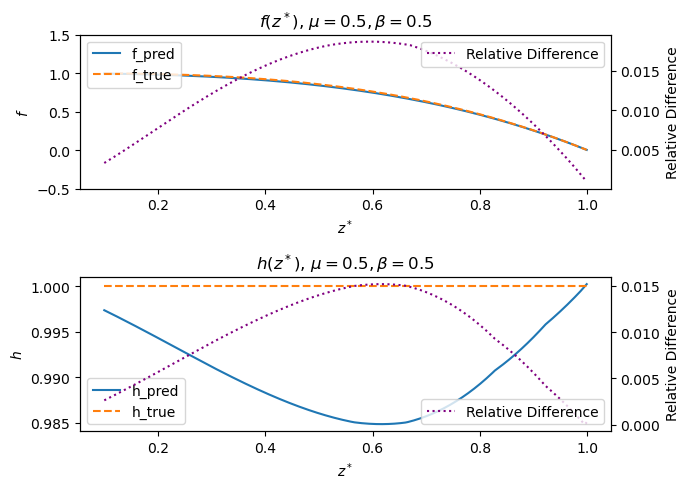

In [79]:
from LinearAxion_NN import _f, _h
from LinearAxion import f, h

zstar_list = torch.tensor(np.linspace(0.10, 0.999, 400), requires_grad=False)

model.eval()
with torch.no_grad():
    f_pred = np.array([_f(model, z).cpu().numpy().squeeze() for z in zstar_list])
    f_true = f(zstar_list, mu, beta)
    h_pred = np.array([_h(model, z).cpu().numpy().squeeze() for z in zstar_list])
    h_true = h(zstar_list)
rel_diff_f = np.abs((f_pred - f_true.detach().cpu().numpy()) / f_true.detach().cpu().numpy())
rel_diff_h = np.abs((h_pred - h_true.detach().cpu().numpy()) / h_true.detach().cpu().numpy())

fig, axs = plt.subplots(2, 1, figsize=(7, 5))
axs[0].plot(zstar_list.detach().cpu().numpy(), f_pred, label="f_pred")
axs[0].plot(zstar_list.detach().cpu().numpy(), f_true.detach().cpu().numpy(), label="f_true", ls="--")
axs[0].set_xlabel("$z^*$")
axs[0].set_ylabel("$f$")
axs[0].set_ylim(-0.5, 1.5)
axs[0].legend(loc='upper left')
ax0twin = axs[0].twinx()
ax0twin.plot(zstar_list.detach().cpu().numpy(), rel_diff_f, label="Relative Difference", color='purple', ls=':')
ax0twin.set_ylabel("Relative Difference")
ax0twin.legend(loc='upper right')
axs[0].set_title(r"$f(z^*)$, $\mu={mu}, \beta={beta}$".format(mu=mu, beta=beta))
axs[1].plot(zstar_list.detach().cpu().numpy(), h_pred, label="h_pred")
axs[1].plot(zstar_list.detach().cpu().numpy(), h_true.detach().cpu().numpy(), label="h_true", ls="--")
axs[1].set_title(r"$h(z^*)$, $\mu={mu}, \beta={beta}$".format(mu=mu, beta=beta))
axs[1].set_xlabel("$z^*$")
axs[1].set_ylabel("$h$")
axs[1].legend(loc='lower left')
ax1twin = axs[1].twinx()
ax1twin.plot(zstar_list.detach().cpu().numpy(), rel_diff_h, label="Relative Difference", color='purple', ls=':')
ax1twin.set_ylabel("Relative Difference")
ax1twin.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [80]:
model.a

Parameter containing:
tensor(-0.0231, requires_grad=True)

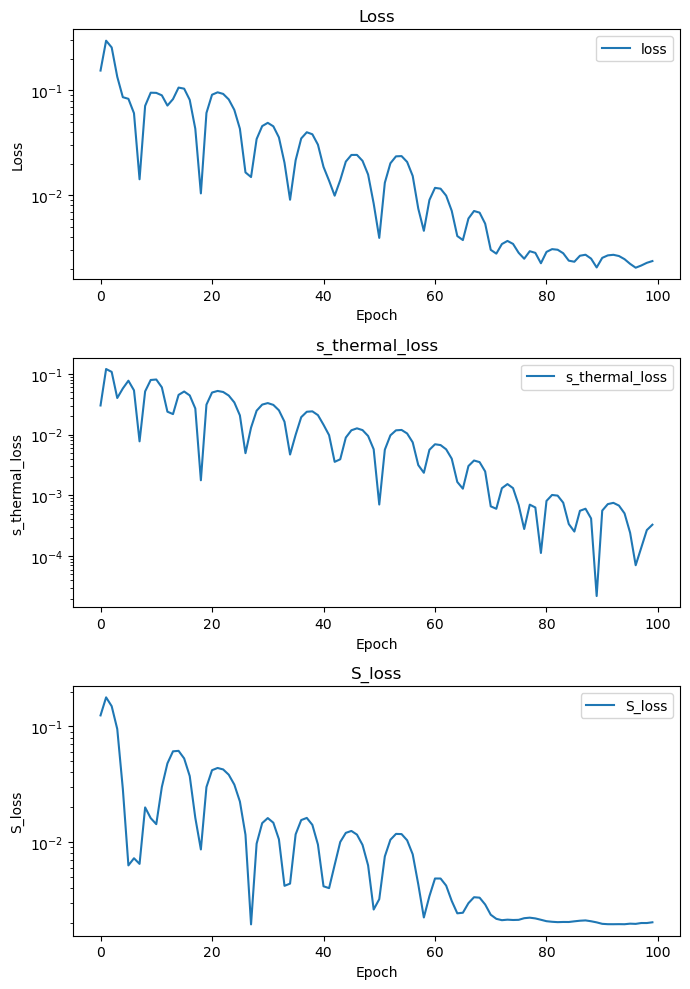

In [81]:
# loss_hist, s_thermal_loss_hist, S_loss_hist, lr_hist
fig, axs = plt.subplots(3, 1, figsize=(7, 10))
axs[0].plot(loss_hist, label="loss")
axs[0].set_title("Loss")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[0].set_yscale("log")
axs[1].plot(s_thermal_loss_hist, label="s_thermal_loss")
axs[1].set_title("s_thermal_loss")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("s_thermal_loss")
axs[1].set_yscale("log")
axs[1].legend()
axs[2].plot(S_loss_hist, label="S_loss")
axs[2].set_title("S_loss")
axs[2].set_xlabel("Epoch")
axs[2].set_ylabel("S_loss")
axs[2].set_yscale("log")
axs[2].legend()
plt.tight_layout()
plt.show()


# PySR Symbolic Regression

In [82]:
zstars = zstar_list.detach().cpu().numpy()
(f_pred.shape, h_pred.shape, zstars.shape)

((400,), (400,), (400,))

In [83]:
from pysr import PySRRegressor

pysr_model = PySRRegressor(
    binary_operators=["+", "*"],
    # unary_operators=["inv(x) = 1/x"],
    # extra_sympy_mappings={"inv": lambda x: 1/x},
    niterations=1000,
    population_size=100,
    model_selection="best",
    maxsize=20,
    verbosity=1,
)

In [84]:
pysr_model.fit(
    zstars.reshape(-1, 1),
    f_pred,
)

/home/bigbogo/miniconda3/envs/3.10/lib/python3.10/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 4.140e+05
Progress: 735 / 31000 total iterations (2.371%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           8.061e-02  0.000e+00  y = 0.69809
5           8.102e-03  5.744e-01  y = (x₀ * -1.035) + 1.2668
7           1.131e-03  9.846e-01  y = ((x₀ * x₀) * -0.96462) + 1.0546
9           1.159e-04  1.139e+00  y = ((x₀ * (x₀ * -0.99296)) * x₀) + 0.97364
11          7.281e-07  2.535e+00  y = (x₀ * (((x₀ * -0.89329) * x₀) + -0.11698)) + 1.0103
13          2.612e-07  5.126e-01  y = ((((x₀ * x₀) * -0.8316) + -0.066651) * (x₀ + 0.1244)) ...
                                      + 1.012
15          1.021e-08  1.621e+00  y = (((x₀ * -0.1595) + -0.31813) * (x₀ * (x₀ * (x₀ + 1.089...
                                      5)))) + 0.99812
17          1.020e-08  1.0

[ Info: Final population:
[ Info: Results saved to:


PySRRegressor.equations_ = [
	   pick     score                                           equation  \
	0        0.000000                                          0.6980867   
	1        0.574394                      (x0 * -1.0349911) + 1.2668107   
	2        0.984641               ((x0 * x0) * -0.9646166) + 1.0546468   
	3        1.138864        ((x0 * (x0 * -0.9929526)) * x0) + 0.9736351   
	4        2.535066  ((((x0 * -0.893284) * x0) + -0.116983615) * x0...   
	5        0.563445  ((x0 + 0.10014648) * (((x0 * -0.8430405) * x0)...   
	6  >>>>  1.570384  (x0 * (x0 * ((x0 + 1.0849602) * ((x0 * -0.1593...   
	7        0.035650  (((((x0 + 2.507243) * x0) * x0) + 0.029620498)...   
	8        0.000002  ((((x0 * ((x0 + 2.5072525) * x0)) * 0.99915606...   
	
	           loss  complexity  
	0  8.061028e-02           1  
	1  8.101502e-03           5  
	2  1.130620e-03           7  
	3  1.159076e-04           9  
	4  7.280841e-07          11  
	5  2.359281e-07          13  
	6  1.020380e-08          15  
	7  9.501603e-09          17  
	8  9.501567e-09          19  
]

  - outputs/20250526_180714_1cD2Qk/hall_of_fame.csv


The true $f$:
$$1 - \frac{1}{2} \beta^2 z^2 - \left(1 - \frac{1}{2} \beta^2 + \frac{1}{4}\mu^2\right) z^3 + \frac{1}{4}\mu^4 z^4$$

In [85]:
import sympy as sp
from LinearAxion_NN import f_true
# $$1 - \frac{1}{2} \beta^2 z^2 - \left(1 - \frac{1}{2} \beta^2 + \frac{1}{4}\mu^2\right) z^3 + \frac{1}{4}\mu^4 z^4$$
z_sp = sp.symbols('z')
mu_sp = sp.symbols('mu')
beta_sp = sp.symbols('beta')
f_true_sympy = 1 - (1/2) * beta_sp**2 * z_sp**2 - (1 - (1/2) * beta_sp**2 + (1/4) * mu_sp**2) * z_sp**3 + (1/4) * mu_sp**4 * z_sp**4

In [86]:
# set mu=0.5, beta=0.5
f_true_sympy.subs({mu_sp: 0.5, beta_sp: 0.5})

0.015625*z**4 - 0.9375*z**3 - 0.125*z**2 + 1

In [87]:
pysr_f = pysr_model.get_best().sympy_format
# simplify the equation
pysr_f_simplified = sp.simplify(pysr_f)
# expand
pysr_f_simplified = sp.expand(pysr_f_simplified)
print("PySR f equation:")
print(pysr_f_simplified)

PySR f equation:
-0.15931846*x0**4 - 0.492195458225292*x0**3 - 0.346472568167454*x0**2 + 0.9981199


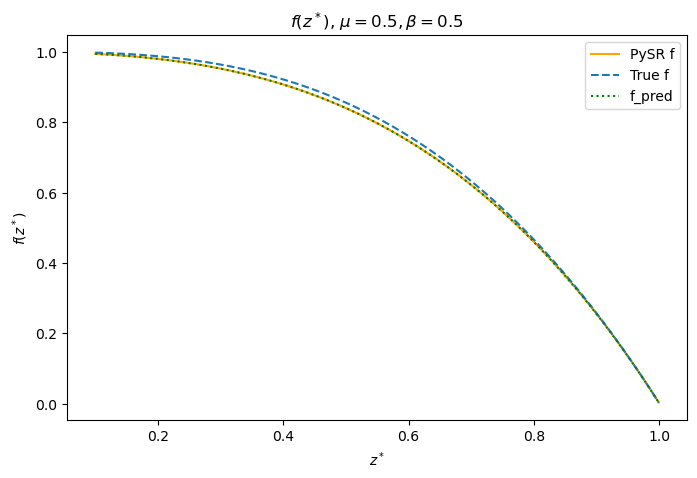

In [88]:
# plot the PySR f equation, the NN f, and the true f equation
zstars_fine = np.linspace(0.1, 0.999, 1000)
f_pred_fine = np.array([pysr_f_simplified.subs({"x0": z, mu_sp: mu, beta_sp: beta}) for z in zstars_fine])
f_true_fine = f_true(torch.tensor(zstars_fine), mu, beta).detach().cpu().numpy()
plt.figure(figsize=(8, 5))
plt.plot(zstars_fine, f_pred_fine, label="PySR f", color='orange')
plt.plot(zstars_fine, f_true_fine, label="True f", ls="--")
plt.plot(zstar_list.detach().cpu().numpy(), f_pred, label="f_pred", color="green", ls=':')
plt.xlabel("$z^*$")
plt.ylabel("$f(z^*)$")
plt.title(r"$f(z^*)$, $\mu={mu}, \beta={beta}$".format(mu=mu, beta=beta))
plt.legend()
plt.show()